In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import cv2
import random
import json
import os
from torch.utils.data import Dataset, DataLoader
import torch, torchvision
import warnings
import numpy as np
import pandas as pd
from tqdm.notebook import tqdm
import torch
import torch.nn as nn
import torchvision
from torch.nn.utils.rnn import pad_sequence

warnings.filterwarnings("ignore")
import ipywidgets as widgets
from ipywidgets import interact, interact_manual
from matplotlib import pyplot as plt
import torch.optim as optim
from torch.optim import lr_scheduler
import torchvision
from torchvision import datasets, models, transforms
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score

In [ ]:
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.style.use('seaborn')
plt.rc('font', size=15)          # controls default text sizes
plt.rc('axes', titlesize=15)     # fontsize of the axes title
plt.rc('axes', labelsize=15)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=15)    # fontsize of the tick labels
plt.rc('ytick', labelsize=15)    # fontsize of the tick labels

from collections import Counter

In [ ]:
import torch
from torch import nn

# If there's a GPU available...
if torch.cuda.is_available():    

    # Tell PyTorch to use the GPU.
    device = torch.device("cuda")

    print('There are %d GPU(s) available.' % torch.cuda.device_count())

    print('We will use the GPU:', torch.cuda.get_device_name(0))

# If not...
else:
    print('No GPU available, using the CPU instead.')
    device = torch.device("cpu")

There are 1 GPU(s) available.
We will use the GPU: Tesla T4


## Download data

In [ ]:
!wget https://lodmedia.hb.bizmrg.com/case_files/815472/train_dataset_train.zip

--2022-10-01 06:22:47--  https://lodmedia.hb.bizmrg.com/case_files/815472/train_dataset_train.zip
Resolving lodmedia.hb.bizmrg.com (lodmedia.hb.bizmrg.com)... 217.69.142.100
Connecting to lodmedia.hb.bizmrg.com (lodmedia.hb.bizmrg.com)|217.69.142.100|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1440670 (1.4M) [application/x-zip-compressed]
Saving to: ‘train_dataset_train.zip’

train_dataset_train 100%[===================>]   1.37M   461KB/s    in 3.0s    

2022-10-01 06:22:52 (461 KB/s) - ‘train_dataset_train.zip’ saved [1440670/1440670]



In [ ]:
!wget https://lodmedia.hb.bizmrg.com/case_files/815472/test_dataset_test.zip 

--2022-10-01 06:22:52--  https://lodmedia.hb.bizmrg.com/case_files/815472/test_dataset_test.zip
Resolving lodmedia.hb.bizmrg.com (lodmedia.hb.bizmrg.com)... 217.69.142.100
Connecting to lodmedia.hb.bizmrg.com (lodmedia.hb.bizmrg.com)|217.69.142.100|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 168003 (164K) [application/x-zip-compressed]
Saving to: ‘test_dataset_test.zip’

test_dataset_test.z 100%[===================>] 164.07K   326KB/s    in 0.5s    

2022-10-01 06:22:53 (326 KB/s) - ‘test_dataset_test.zip’ saved [168003/168003]



In [ ]:
!unzip test_dataset_test.zip -d data
!unzip train_dataset_train.zip -d data

Archive:  test_dataset_test.zip
  inflating: data/test_comments.csv  
  inflating: data/test_issues.csv    
Archive:  train_dataset_train.zip
  inflating: data/train_issues.csv   
  inflating: data/train_comments.csv  


In [ ]:
!pip install catboost -q

     |████████████████████████████████| 76.8 MB 1.2 MB/s 


In [ ]:
!pip install transformers simpletransformers -q

     |████████████████████████████████| 4.9 MB 8.0 MB/s 
     |████████████████████████████████| 250 kB 69.7 MB/s 
     |████████████████████████████████| 6.6 MB 57.3 MB/s 
     |████████████████████████████████| 163 kB 67.7 MB/s 
     |████████████████████████████████| 1.8 MB 49.6 MB/s 
     |████████████████████████████████| 43 kB 1.5 MB/s 
     |████████████████████████████████| 431 kB 54.1 MB/s 
     |████████████████████████████████| 1.3 MB 53.4 MB/s 
     |████████████████████████████████| 9.2 MB 53.6 MB/s 
     |████████████████████████████████| 162 kB 58.3 MB/s 
     |████████████████████████████████| 181 kB 54.0 MB/s 
     |████████████████████████████████| 63 kB 1.8 MB/s 
     |████████████████████████████████| 158 kB 47.7 MB/s 
     |████████████████████████████████| 157 kB 47.5 MB/s 
     |████████████████████████████████| 157 kB 56.6 MB/s 
     |████████████████████████████████| 157 kB 54.6 MB/s 
     |████████████████████████████████| 157 kB 6.8 MB/s 
     |██████████████

## EDA (Запускать не обязательно)

In [ ]:
comments = pd.read_csv('data/train_comments.csv')
data = pd.read_csv('data/train_issues.csv')
# data = data[data['overall_worklogs'] < 300000]

In [ ]:
comments['text'].apply(lambda x: 'https://gitlab.' in x).value_counts()

False    9788
True     4130
Name: text, dtype: int64

In [ ]:
comments.head()

,comment_id,text,issue_id,author_id
0,11779,[https://www.youtube.com/watch?v=tuhOdtsvoNY|h...,669666,1
1,10601,OK [~accountid:557058:3f7ab89a-8969-4547-90df-...,669670,1
2,76101,I encountered a problem with access to `/users...,670930,2
3,76102,I have learned that `users/:id/emails` endpoin...,670930,2
4,76213,We have decided with Andrew to set member's em...,670930,2


In [ ]:
comments['text'].tolist()[:10]

['[https://www.youtube.com/watch?v=tuhOdtsvoNY|https://www.youtube.com/watch?v=tuhOdtsvoNY]\nthanks this gay, he help me \n\nfinish test. It works on grafana.maddevs.co',
 'OK [~accountid:557058:3f7ab89a-8969-4547-90df-53b125e262f7] thanka for the update and the message slack. ',
 "I encountered a problem with access to `/users/:id/emails` endpoint.\xa0\r\n\r\nAs GitLab API documentation says I need to have an `admin` role but now I was checking group where I'm `owner`.",
 "I have learned that `users/:id/emails` endpoint available only for self-managed Gitlab instances.\xa0\r\nHowever, we already have users` emails according to project commits. Hence, we may use them for matching.\xa0\r\n\r\nBut we wouldn't know about the user`s email until he pushes a commit.\r\n\r\n[~chaka]\xa0fyi",
 "We have decided with Andrew to set member's email manually 'cause currently, we have to show up to our main graph.",
 'I have read the neo4j documentation and also I was able to get all users by using t

In [ ]:
 data['created'] = pd.to_datetime(data['created'])
 data.head()

,id,created,key,summary,project_id,assignee_id,creator_id,overall_worklogs
0,819952,2019-10-01 05:57:18,SM-10678,"UI тесты по заказу ""Добро КейДжи""",5,93,93,1800
1,819949,2019-10-01 05:59:45,SM-10679,"UI тесты раздела ""Профиль""",5,93,93,7200
2,819947,2019-10-01 06:00:38,SM-10680,"UI тесты раздела ""Личный счет""",5,93,93,14400
3,819943,2019-10-01 06:02:49,SM-10682,"UI тесты раздела ""Новости""",5,93,93,900
4,819941,2019-10-01 06:03:26,SM-10683,"UI тесты раздела ""Зоны скидок и доплат""",5,93,93,900


In [ ]:
projects = data.groupby('project_id')['creator_id'].unique()
num_projects = len(projects)

inter = np.zeros((num_projects, num_projects))
for i in range(num_projects):
    for j in range(num_projects):
        inter[i][j] = len(set(projects.iloc[i]) & set(projects.iloc[j]))
inter

array([[10.,  3.,  1.,  3.,  2.,  2.,  0.],
       [ 3., 29.,  6.,  8.,  5.,  3.,  0.],
       [ 1.,  6.,  8.,  3.,  3.,  1.,  0.],
       [ 3.,  8.,  3., 19.,  3.,  2.,  0.],
       [ 2.,  5.,  3.,  3.,  8.,  2.,  0.],
       [ 2.,  3.,  1.,  2.,  2.,  4.,  0.],
       [ 0.,  0.,  0.,  0.,  0.,  0.,  1.]])

In [ ]:
data.groupby(data['created'].dt.weekday)['overall_worklogs'].mean()

created
0    14270.969313
1    14961.316998
2    12574.920183
3    14323.708381
4    12342.287234
5     9780.740741
6    11088.994083
Name: overall_worklogs, dtype: float64

In [ ]:
data.groupby(data['created'].dt.weekday)['overall_worklogs'].count()

created
0    2053
1    1959
2    1967
3    1742
4    1504
5     162
6     169
Name: overall_worklogs, dtype: int64

In [ ]:
data.groupby(data['created'].dt.hour)['overall_worklogs'].mean()

created
0     30794.000000
1     28013.684211
2     26840.322581
3     29448.510638
4     14752.067797
5     13722.964119
6     14390.603248
7     12687.088036
8     12642.084309
9     12558.444444
10    13028.996540
11    13311.308411
12    11198.992974
13    12295.933735
14    14201.175904
15    13124.356436
16    13484.066390
17    13334.318182
18    14466.417112
19    18008.205128
20    19594.090909
21    23474.347826
22     7730.000000
23    13994.000000
Name: overall_worklogs, dtype: float64

In [ ]:
data.groupby(data['created'].dt.hour)['overall_worklogs'].count()

created
0      30
1      19
2      62
3     141
4     295
5     641
6     862
7     886
8     854
9     810
10    867
11    856
12    854
13    664
14    415
15    303
16    241
17    264
18    187
19    117
20     88
21     46
22     24
23     30
Name: overall_worklogs, dtype: int64

In [ ]:
x = data.groupby([data['created'].dt.weekday.rename("weekday"), data['created'].dt.hour.rename("hour")])['overall_worklogs'].agg(['mean']).reset_index()
x.head()

,weekday,hour,mean
0,0,0,15960.000000
1,0,1,3600.000000
2,0,2,18750.000000
3,0,3,12594.782609
4,0,4,18265.000000


In [ ]:
x[x['weekday'] == 5]

,weekday,hour,mean
120,5,0,12936.000000
121,5,2,7800.000000
122,5,3,51000.000000
123,5,4,1800.000000
124,5,5,11605.714286
125,5,6,25050.000000
126,5,7,7686.000000
127,5,8,9814.285714
128,5,9,6752.727273
129,5,10,11226.315789


In [ ]:
x[x['weekday'] == 0]

,weekday,hour,mean
0,0,0,15960.000000
1,0,1,3600.000000
2,0,2,18750.000000
3,0,3,12594.782609
4,0,4,26857.377049
5,0,5,17452.075472
6,0,6,14976.172249
7,0,7,13577.222222
8,0,8,13904.693878
9,0,9,10241.562500


In [ ]:
(data['creator_id'] == data['assignee_id']).mean()

0.6710814474919178

In [ ]:
comments.groupby('issue_id')['comment_id'].count().mean()

3.5280101394169834

In [ ]:
test_data = pd.read_csv('data/test_issues.csv')
test_comments = pd.read_csv('data/test_comments.csv')

In [ ]:
len(set(test_data['assignee_id']) & set(data['assignee_id'])), data['assignee_id'].nunique(), test_data['assignee_id'].nunique()

(25, 51, 28)

In [ ]:
len(set(test_data['creator_id']) & set(data['creator_id'])), data['creator_id'].nunique()

(26, 52)

In [ ]:
len(set(test_data['project_id']) & set(data['project_id'])), data['project_id'].nunique()

(7, 7)

In [ ]:
test_data['created'].apply(lambda x: str(x)[:4]).unique()

array(['2020', '2021'], dtype=object)

In [ ]:
data['created'].apply(lambda x: str(x)[:4]).unique()

array(['2019', '2020', '2018', '2017', '2021'], dtype=object)

In [ ]:
comments.groupby('issue_id')['text'].count().mean()

3.5280101394169834

## Feature engeneering

In [ ]:
def build_text(x):
    return x.summary + ' [SEP] '# + x.comments #   #f"project id: {x.project_id}, assignee id: {x.assignee_id}, creator id: {x.creator_id}"

In [ ]:
def make_harmonic_features(value, period=24):
    value *= 2 * np.pi / period
    return np.cos(value), np.sin(value)

In [ ]:
# train, _ = train_test_split(pd.read_csv('data/train_issues.csv'), test_size=0.2, random_state=42, )
train = pd.read_csv('data/train_issues.csv')
# train = train[train['overall_worklogs'] < 500000]
train['created'] = pd.to_datetime(train['created'])
train['weekday'] = train['created'].dt.weekday
train['hour'] = train['created'].dt.hour

pair_cols = [('assignee_id', 'project_id'), ('creator_id', 'project_id')] # ('assignee_id', 'creator_id')
pair_col_names = []
for c in pair_cols:
    train[c[0] + '_' + c[1]] = train[c[0]].astype(str) + '_' + train[c[1]].astype(str)
    pair_col_names.append(c[0] + '_' + c[1])

agg = {}

for col_name in ['project_id', 'assignee_id', 'creator_id', 'hour', 'weekday'] + pair_col_names:
    x = train.groupby(col_name)['overall_worklogs'].mean().reset_index()
    x = {k: v for k, v in zip(x[col_name], x['overall_worklogs'])}
    agg[col_name] = x

In [ ]:
# all_data, _ = train_test_split(pd.read_csv('data/train_issues.csv'), test_size=0.2, random_state=42, )
all_data = pd.concat([pd.read_csv('data/train_issues.csv')]) #, pd.read_csv('data/test_issues.csv')
all_data['created'] = pd.to_datetime(all_data['created'])
all_data = all_data.sort_values(by='created')
all_data = all_data.reset_index()
all_data.head()

,index,id,created,key,summary,project_id,assignee_id,creator_id,overall_worklogs
0,7250,700722,2017-10-05 10:01:14,UN-1,Изучить API для приложения Элкарт,15,22,37,14400
1,7251,700721,2017-10-05 10:08:53,UN-2,Изучить дизайн приложения по скриншотам в прил...,15,1,37,25200
2,7252,700719,2017-10-06 07:45:43,UN-4,Дизайн экрана регистрации,15,1,37,10800
3,7253,700718,2017-10-06 08:02:02,UN-5,Верстка формы регистрации нового пользователя,15,13,37,32400
4,7254,700716,2017-10-06 08:37:59,UN-7,Ввод одноразового кода,15,13,37,10800


In [ ]:
def get_time_to_next_mention(assignee_id, created):
    now = all_data[all_data['assignee_id'] == assignee_id]
    now = now[now['created'] > created]
    if len(now) == 0: 
        return None
    next_time = now.iloc[0]['created']
    
    return len(all_data[(all_data['created'] <= next_time) & (all_data['created'] >= created)]) #(next_time - created).total_seconds()

In [ ]:
import re 

def get_data(issues_path, comments_path):
    comments = pd.read_csv(comments_path)
    comments = comments.groupby('issue_id')['text'].agg(['count', lambda x: '. '.join(x)]).reset_index()
    comments = comments.rename(columns={'<lambda_0>': 'comments'})
    # train_comments.head()

    data = pd.read_csv(issues_path)
    data = data.merge(comments, how='left', left_on='id', right_on='issue_id')

    data = data.sort_values(by='created')
    data['created'] = pd.to_datetime(data['created'])
    # data['time_to_next_mention'] = data.apply(lambda x: get_time_to_next_mention(x.assignee_id, x.created), axis=1)

    data['assignee=creator'] = data['assignee_id'] == data['creator_id']
    data['count'] = data['count'].fillna(0)
    data['comments'] = data['comments'].fillna('.')
    data['comments'] = data['comments'].apply(lambda x: re.sub('(http|ftp|https):\/\/([\w_-]+(?:(?:\.[\w_-]+)+))([\w.,@?^=%&:\/~+#-]*[\w@?^=%&\/~+#-])', '', x))
    # data['len_comments'] = data['comments'].apply(lambda x: len(x))

    # time features
    data['weekday'] = data['created'].dt.weekday
    data['hour'] = data['created'].dt.hour

    # data['week_day_cos'] = data['weekday'].apply(lambda x: make_harmonic_features(x, 7)[0])
    # data['week_day_sin'] = data['weekday'].apply(lambda x: make_harmonic_features(x, 7)[1])
    # data['hour_cos'] = data['hour'].apply(lambda x: make_harmonic_features(x, 24)[0])
    # data['hour_sin'] = data['hour'].apply(lambda x: make_harmonic_features(x, 24)[1])
    
    # add agg
    for c in pair_cols:
        data[c[0] + '_' + c[1]] = data[c[0]].astype(str) + '_' + data[c[1]].astype(str)

    for col_name in agg.keys():
        data[col_name + '_mean_target'] = data[col_name].apply(lambda x: agg[col_name][x] if x in agg[col_name].keys() else None)

    # compute sum by agg
    # data['creator+assignee+project'] = (data['assignee_id_mean_target'] + data['creator_id_mean_target'] + data['project_id_mean_target']) / 3
    # data['creator+assignee+project+hour'] = (data['creator+assignee+project'] * 3 + data['hour_mean_target']) / 4
    # data['creator+assignee+project+hour'] = (data['creator+assignee+project+hour'] * 4 + data['weekday_mean_target']) / 5

    if 'overall_worklogs' in data.columns:
        data['target'] = data['overall_worklogs']

    data = data.drop(['issue_id', 'created', 'key', 'hour', 'weekday'] + pair_col_names, 1)
    return data

In [ ]:
MAX_SEQ_LEN = 256
test_size = len(pd.read_csv('data/test_issues.csv'))

In [ ]:
data = pd.concat([get_data('data/train_issues.csv', 'data/train_comments.csv'),
                  get_data('data/test_issues.csv', 'data/test_comments.csv')])
data.head()

,id,summary,project_id,assignee_id,creator_id,overall_worklogs,count,comments,assignee=creator,project_id_mean_target,assignee_id_mean_target,creator_id_mean_target,hour_mean_target,weekday_mean_target,assignee_id_project_id_mean_target,creator_id_project_id_mean_target,target
7250,700722,Изучить API для приложения Элкарт,15,22,37,14400.0,0.0,.,False,17603.13253,12119.178082,15388.8,16588.620690,18252.171429,12119.178082,15421.721311,14400.0
7251,700721,Изучить дизайн приложения по скриншотам в прил...,15,1,37,25200.0,2.0,они еще исходники нам присылали фотошопные. [~...,False,17603.13253,24463.448498,15388.8,16588.620690,18252.171429,14807.832168,15421.721311,25200.0
7252,700719,Дизайн экрана регистрации,15,1,37,10800.0,5.0,Завтра с утра подготовлю ссылки для демонстрац...,False,17603.13253,24463.448498,15388.8,13135.535513,13383.740053,14807.832168,15421.721311,10800.0
7253,700718,Верстка формы регистрации нового пользователя,15,13,37,32400.0,0.0,.,False,17603.13253,14708.108108,15388.8,12642.084309,13383.740053,14708.108108,15421.721311,32400.0
7254,700716,Ввод одноразового кода,15,13,37,10800.0,0.0,.,False,17603.13253,14708.108108,15388.8,12642.084309,13383.740053,14708.108108,15421.721311,10800.0


In [ ]:
data.shape

(10659, 17)

In [ ]:
len(data)

10659

## Finetune bert

In [ ]:
(df_train, df_val), df_test = train_test_split(data[:-test_size], test_size=0.2, random_state=42, ), data[-test_size:]

In [ ]:
df_train = df_train[df_train['overall_worklogs'] < 300000]

X_train = df_train.apply(build_text, axis=1)
y_train = df_train['target'].astype(np.float)

X_val = df_val.apply(build_text, axis=1)
y_val = df_val['target'].astype(np.float)

X_test = df_test.apply(build_text, axis=1)

In [ ]:
train_df = pd.DataFrame({
    'text': X_train,
    'labels':y_train
})

print(train_df.head())

eval_df = pd.DataFrame({
    'text': X_val,
    'labels': y_val
})

print(eval_df.head())

                                                   text   labels
7706  Верстка страницы для сообщения отсутствия мини...   7200.0
3834           Add spinner into profile buttons [SEP] .   3300.0
4091                     Notifications dropdown [SEP] .  55200.0
8827  Customer Feedback 139-160 [SEP] [Maksim Gaches...  43800.0
9148  Remove livechat minerva [SEP] [~khietbt] pls r...   4200.0
                                                   text   labels
5145  Test LessonTemplateController:destroy() method...  10800.0
4230  When scrolling, the button disappears from the...    900.0
39    PushNotificationReceiver.java [SEP] Почти все ...  19800.0
2766  Journey Lesson Details [SEP] [Roman Chasovitin...   3000.0
1840                                Test layout [SEP] .   2400.0


In [ ]:
from simpletransformers.classification import ClassificationModel, ClassificationArgs
model_args = ClassificationArgs(#learning_rate = 2e-6,
                                # num_train_epochs = 3,
                                # adam_epsilon = 1e-8,
                                #warmup_proportion = 0.1,
                                #weight_decay = 0.01,
                                #load_best_model_at_end = True,
                                #metric_for_best_model = 'matthews_correlation',
                                # train_batch_size = 16,
                                manual_seed = 42,
                                regression=True,
                                )

model = ClassificationModel('bert', 'bert-base-multilingual-cased', num_labels=1, use_cuda=True, args=model_args)

Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForSequenceClassification: ['cls.seq_relationship.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model ch

In [ ]:
train_args = {'learning_rate' : 2e-6,
              'max_seq_length' : MAX_SEQ_LEN,
              'num_train_epochs' : 4,
              #'do_lower_case' : True,
              'use_multiprocessing' : True,
              'train_batch_size' : 4,
              #'save_steps' : 50000,
              'eval_bacth_size' : 8,
              'overwrite_output_dir': True,
              'warmup_proportion' : 0.1,
              'weight_decay' : 0.01,
              'load_best_model_at_end' : True,
            #   'metric_for_best_model' : 'matthews_correlation',
              }
model.train_model(train_df = train_df, eval_df = eval_df, output_dir='outputs', args = train_args)
#result, model_outputs, wrong_predictions = model.eval_model(eval_df)

  0%|          | 0/7645 [00:00<?, ?it/s]

Epoch:   0%|          | 0/4 [00:00<?, ?it/s]

Running Epoch 0 of 4:   0%|          | 0/1912 [00:00<?, ?it/s]

Running Epoch 1 of 4:   0%|          | 0/1912 [00:00<?, ?it/s]

Running Epoch 2 of 4:   0%|          | 0/1912 [00:00<?, ?it/s]

Running Epoch 3 of 4:   0%|          | 0/1912 [00:00<?, ?it/s]

(7648, 662832216.194953)

In [ ]:
preds, raw_outputs = model.predict(X_val.tolist())
r2_score(df_val['overall_worklogs'], preds) #summary + comments

  0%|          | 0/1918 [00:00<?, ?it/s]

  0%|          | 0/240 [00:00<?, ?it/s]

-0.1085368673921725

In [ ]:
preds, raw_outputs = model.predict(X_val.tolist())
r2_score(df_val['overall_worklogs'], preds) #only summary xlm-roberta

  0%|          | 0/1918 [00:00<?, ?it/s]

  0%|          | 0/240 [00:00<?, ?it/s]

-0.10852942243425834

In [ ]:
preds, raw_outputs = model.predict(X_val.tolist())
r2_score(df_val['overall_worklogs'], preds) #summary + params

  0%|          | 0/1918 [00:00<?, ?it/s]

  0%|          | 0/240 [00:00<?, ?it/s]

-0.10858697659660832

In [ ]:
preds, raw_outputs = model.predict(X_val.tolist())
r2_score(df_val['overall_worklogs'], preds) #only summary

  0%|          | 0/1918 [00:00<?, ?it/s]

  0%|          | 0/240 [00:00<?, ?it/s]

-0.10858727849707872

In [ ]:
model.model.save_pretrained('/content/drive/MyDrive/datasets/Collector/bert_model_summary_comments')

## Get bert embeddings

In [ ]:
from transformers import AutoTokenizer
from transformers import AutoModel

tokenizer = AutoTokenizer.from_pretrained('bert-base-multilingual-cased') # 'xlm-roberta-base'
text_model = AutoModel.from_pretrained('bert-base-multilingual-cased').to(device)

Downloading:   0%|          | 0.00/29.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/625 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/996k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.96M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/714M [00:00<?, ?B/s]

Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertModel: ['cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.weight', 'cls.predictions.decoder.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [ ]:
bert_model = AutoModel.from_pretrained('/content/drive/MyDrive/datasets/Collector/bert_model_summary').to(device)

Some weights of the model checkpoint at /content/drive/MyDrive/datasets/Collector/bert_model_summary were not used when initializing BertModel: ['classifier.bias', 'classifier.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [ ]:
bert_model = bert_model.eval()

In [ ]:
bert_model.dropout = nn.Sequential()
bert_model.classifier = nn.Sequential()

In [ ]:
encoded_dict = tokenizer.encode_plus(
                            # data['text'][0].split('[SEP]')[0],
                            # data['text'][0].split('[SEP]')[1],
                            data['summary'][0],
                            add_special_tokens = True,
                            return_token_type_ids = True,
                            max_length = MAX_SEQ_LEN,
                            truncation = True,
                            pad_to_max_length = True,
                            return_attention_mask = True,
                            return_tensors = 'pt',
                    )
encoded_dict = {k: v.to(device) for k, v in encoded_dict.items()}

In [ ]:
res = bert_model(**encoded_dict, return_dict=False)

In [ ]:
res[1].shape

torch.Size([1, 768])

In [ ]:
def get_bert_embeddings(text):
    encoded_dict = tokenizer.encode_plus(
                            text.split('[SEP]')[0],
                            text.split('[SEP]')[1],
                            # text,
                            add_special_tokens = True,
                            return_token_type_ids = True,
                            max_length = MAX_SEQ_LEN,
                            truncation = True,
                            pad_to_max_length = True,
                            return_attention_mask = True,
                            return_tensors = 'pt',
                    )
    encoded_dict = {k: v.to(device) for k, v in encoded_dict.items()}
    # res = bert_model(**encoded_dict)[1]
    res = bert_model(**encoded_dict, return_dict=False)[1]
    return res.cpu().detach().numpy()

In [ ]:
build_text(next(iter(data.iterrows()))[1])

'Изучить API для приложения Элкарт [SEP] '

In [ ]:
summary_embeddings = np.array([get_bert_embeddings(build_text(el[1])) for el in tqdm(list(data.iterrows()))])
summary_embeddings = summary_embeddings.squeeze()
summary_embeddings.shape

  0%|          | 0/10659 [00:00<?, ?it/s]

(10659, 768)

In [ ]:
with open('/content/drive/MyDrive/datasets/Collector/embeddings.np', 'rb') as f:
    summary_embeddings = np.load(f)
summary_embeddings.shape

(10659, 768)

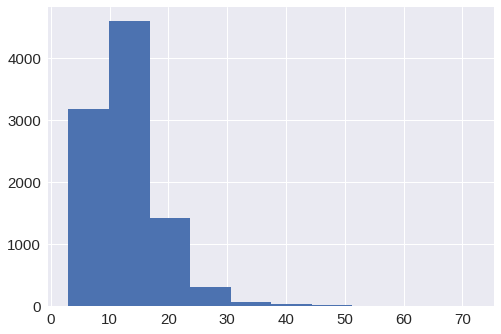

In [ ]:
plt.hist([len(tokenizer.encode_plus(text)['input_ids']) for text in data['summary']])
plt.show()

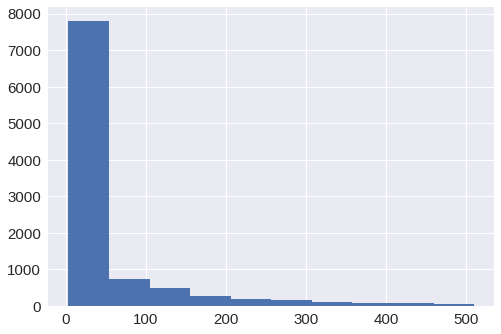

In [ ]:
cnt = np.array([len(tokenizer.encode_plus(text)['input_ids']) for text in data['comments']])
plt.hist(cnt[cnt < 512])
plt.show()

## Add embeddings and make pool

In [ ]:
# data[['emb_summary_{}'.format(i) for i in range(text_embeddings.shape[1])]] = text_embeddings
data[['emb_summary_{}'.format(i) for i in range(summary_embeddings.shape[1])]] = summary_embeddings

In [ ]:
# data['summary_embedding'] = summary_embeddings.tolist()

In [ ]:
data.shape

(10659, 785)

## Model defining

In [ ]:
from catboost import CatBoostRegressor, CatBoostClassifier, Pool

In [ ]:
cat_cols = ['creator_id', 'assignee_id', 'project_id'] #, 'hour', 'weekday'
emb_cols = [] #['summary_embedding']

## Train classifier (Запускать не обязательно)

In [ ]:
(df_train, df_val), df_test = train_test_split(data[:-test_size], test_size=0.2, random_state=42, ), data[-test_size:]

In [ ]:
X_train_clf = df_train.drop(drop_cols, axis=1)
y_train_clf = df_train['target'] > 300000

X_val_clf = df_val.drop(drop_cols, axis=1)
y_val_clf = df_val['target'] > 300000

X_test_clf = df_test.drop(drop_cols, axis=1)

In [ ]:
y_train_clf.sum(), y_val_clf.sum()

(26, 7)

In [ ]:
params = {'n_estimators' : 3000,
          'learning_rate': .03,
          'max_depth' : 6,
          'cat_features' : cat_cols,
          # 'border_count' : 64,
#           'l2_leaf_reg' : 1,
          # 'bagging_temperature' : 2,
          # 'rsm' : .1,
          'use_best_model': True,
          'task_type': 'GPU',
          'random_state': 42,
         }

In [ ]:
clf = CatBoostClassifier(**params)

In [ ]:
clf.fit(X_train_clf, y_train_clf, verbose=500, eval_set=(X_val_clf, y_val_clf), early_stopping_rounds=200) #

0:	learn: 0.6073830	test: 0.6078764	best: 0.6078764 (0)	total: 155ms	remaining: 7m 44s
bestTest = 0.01953543065
bestIteration = 225
Shrink model to first 226 iterations.


In [ ]:
from sklearn.metrics import *
import seaborn as sns

predictions = clf.predict_proba(X_val_clf)[:, 1] > 0.04

print("Precision: {0:6.2f}".format(precision_score(y_val_clf, predictions, average='macro')))
print("Recall: {0:6.2f}".format(recall_score(y_val_clf, predictions, average='macro')))
print("F1-measure: {0:6.2f}".format(f1_score(y_val_clf, predictions, average='macro')))
print("Accuracy: {0:6.2f}".format(accuracy_score(y_val_clf, predictions)))

# labels = [0, 1]
# sns.heatmap(data=confusion_matrix(y_val, predictions), annot=True, fmt="d", cbar=False, xticklabels=labels, yticklabels=labels)
# plt.title("Confusion matrix")
# plt.show()

Precision:   0.75
Recall:   0.57
F1-measure:   0.61
Accuracy:   1.00


In [ ]:
y_val_clf.sum()

7

In [ ]:
predictions.sum()

2

## Train regressor

In [ ]:
(df_train, df_val), df_test = train_test_split(data[:-test_size], test_size=0.2, random_state=42, ), data[-test_size:]

In [ ]:
add = 1500
df_train = pd.concat([df_train, df_val[:add]])
df_val = df_val[add:]

In [ ]:
drop_cols = ['overall_worklogs', 'target', 'comments',  'summary', 'id']

df_train = df_train[df_train['overall_worklogs'] < 300000]
# df_val = df_val[df_val['overall_worklogs'] < 300000]

X_train = df_train.drop(drop_cols, axis=1)
y_train = df_train['target']

X_val = df_val.drop(drop_cols, axis=1)
y_val = df_val['target']

X_test = df_test.drop(drop_cols, axis=1)

In [ ]:
params = {'n_estimators' : 3000,
          'learning_rate': .03,
          'max_depth' : 6,
          'cat_features' : cat_cols,
          'embedding_features': emb_cols,
          # 'border_count' : 64,
          'l2_leaf_reg' : 2,
          # 'bagging_temperature' : 2,
        #   'rsm' : .1,
          'use_best_model': False,
          'task_type': 'GPU',
          'random_state': 42,
         }

In [ ]:
model = CatBoostRegressor(**params)

In [ ]:
model.fit(X_train, y_train, verbose=500, eval_set=(X_val, y_val), early_stopping_rounds=None)

0:	learn: 22610.2339393	test: 167187.7910572	best: 167187.7910572 (0)	total: 161ms	remaining: 8m 3s
500:	learn: 17583.9812190	test: 166241.1382124	best: 166221.1806784 (394)	total: 36.4s	remaining: 3m 1s
1000:	learn: 16109.9754392	test: 166083.5555962	best: 166079.5907030 (955)	total: 1m 6s	remaining: 2m 12s
1500:	learn: 15111.8310711	test: 165930.0262200	best: 165904.0663258 (1310)	total: 1m 40s	remaining: 1m 39s
2000:	learn: 14438.7631955	test: 165862.3133282	best: 165855.8248672 (1982)	total: 2m 10s	remaining: 1m 4s
2500:	learn: 13862.8941612	test: 165832.7955874	best: 165828.9078992 (2491)	total: 2m 49s	remaining: 33.8s
2999:	learn: 13407.6843995	test: 165736.7414840	best: 165730.4524477 (2965)	total: 3m 19s	remaining: 0us
bestTest = 165730.4524
bestIteration = 2965


In [ ]:
preds = model.predict(X_val[y_val < 300000])
r2_score(df_val[y_val < 300000]['overall_worklogs'], preds) #summary + agg[+hour, weekday, 2 pair] + lick + bert + <300k on val

0.2540192654230329

In [ ]:
preds = model.predict(Pool(X_val[y_val < 300000], cat_features=cat_cols, embedding_features=emb_cols))
r2_score(df_val[y_val < 300000]['overall_worklogs'], preds) #summary + agg[+hour, weekday, 2 pair] + lick + bert + <300k on val

0.23545620371465048

In [ ]:
preds = model.predict(Pool(X_val[y_val < 300000], cat_features=cat_cols, embedding_features=emb_cols))
r2_score(df_val[y_val < 300000]['overall_worklogs'], preds) #summary + agg[+hour, weekday, 2 pair] + lick + bert + <300k on val

0.20106152117965415

In [ ]:
preds = model.predict(Pool(X_val[y_val < 300000], cat_features=cat_cols, embedding_features=emb_cols))
r2_score(df_val[y_val < 300000]['overall_worklogs'], preds) #summary + agg[+hour, weekday, 2 pair] + lick + bert + <300k on val

0.23340351879841703

## Train Meata Model with diff random state

In [ ]:
from sklearn.model_selection import StratifiedKFold
import copy

class MetaModel:
    def __init__(self, params):
        self.models = []
        self.params = params
        self.scores = []
        
    def fit(self, **kwargs):
        self.models = []
        self.scores = []
        
        for i in range(5):
            now_params = self.params.copy()
            now_params['random_state'] = 42 + i
            now_model = CatBoostRegressor(**now_params)
            now_model.fit(**kwargs)

            preds = now_model.predict(X_val[y_val < 300000])
            acc = r2_score(df_val[y_val < 300000]['overall_worklogs'], preds)
            print(f'Random state {i + 42} r2 = {acc}')
            
            self.scores.append(acc)
            self.models.append(now_model)
        print('Mean acc = {}'.format(np.mean(self.scores)))
    
    def predict(self, X):
        if len(self.models) == 0:
            raise Exception("There is not fitted model")
            
        preds = np.concatenate([model.predict(X).reshape(-1, 1) for model in self.models], axis=1)
        return preds.mean(axis=1)

In [ ]:
meta_model = MetaModel(params)
meta_model.fit(X=X_train, y=y_train, verbose=500, eval_set=(X_val, y_val), early_stopping_rounds=200)

0:	learn: 22255.5339626	test: 96911.7002445	best: 96911.7002445 (0)	total: 114ms	remaining: 5m 42s
500:	learn: 16892.6040065	test: 95637.9013435	best: 95637.3754348 (496)	total: 33.6s	remaining: 2m 47s
1000:	learn: 15028.8134022	test: 95391.3303131	best: 95388.4274373 (987)	total: 1m 3s	remaining: 2m 6s
1500:	learn: 13898.5535546	test: 95320.8339413	best: 95320.8339413 (1500)	total: 1m 32s	remaining: 1m 32s
2000:	learn: 13169.1281760	test: 95269.5428258	best: 95268.9747141 (1956)	total: 2m 4s	remaining: 1m 2s
2500:	learn: 12659.4604339	test: 95224.6687839	best: 95224.4563597 (2499)	total: 2m 33s	remaining: 30.7s
2999:	learn: 12216.2051084	test: 95202.8669937	best: 95201.9137334 (2996)	total: 3m 2s	remaining: 0us
bestTest = 95201.91373
bestIteration = 2996
Shrink model to first 2997 iterations.
Random state 42 r2 = 0.20106152117965415
0:	learn: 22238.0730947	test: 96911.1812484	best: 96911.1812484 (0)	total: 65.7ms	remaining: 3m 17s
500:	learn: 17011.3497281	test: 95687.5409585	best: 95

In [ ]:
preds = meta_model.predict(X_val[y_val < 300000])
r2_score(df_val[y_val < 300000]['overall_worklogs'], preds) #summary + agg[+hour, weekday, 2 pair] + lick + bert + <300k on val

0.19645638347328298

## Train with cross validation

In [ ]:
from sklearn.model_selection import StratifiedKFold
import copy

class CvModel:
    def __init__(self, clf):
        self.models = []
        self.clf = clf
        self.scores = []
        
    def fit(self, X, y, cv=5):
        self.models = []
        self.scores = []
        
        skf = StratifiedKFold(n_splits=cv)
        for i, (train_idx, test_idx) in enumerate(skf.split(X, y)):
            now_model = copy.deepcopy(self.clf)
            X_train, X_val, y_train, y_val = X.loc[train_idx], X.loc[test_idx], y.loc[train_idx], y.loc[test_idx]
            X_train, y_train = X_train[y_train < 300000], y_train[y_train < 300000]
            # X_val, y_val = X_val[y_val < 300000], y_val[y_val < 300000]
            # print('creator_id' in X_train.columns)

            now_model.fit(X_train, y_train, verbose=1000, eval_set=(X_val, y_val), early_stopping_rounds=200)
            acc = r2_score(y_val, now_model.predict(X_val))
            print(f'Fold {i}/{cv - 1} acc = {acc}')
            
            self.scores.append(acc)
            self.models.append(now_model)
        print('Mean acc = {}'.format(np.mean(self.scores)))
            
    def predict_proba(self, X):
        if len(self.models) == 0:
            raise Exception("There is not fitted model")
            
        res = [model.predict_proba(X) for model in self.models]
        return np.mean(res, axis=1)
    
    def predict(self, X):
        if len(self.models) == 0:
            raise Exception("There is not fitted model")
            
        preds = np.concatenate([model.predict(X).reshape(-1, 1) for model in self.models], axis=1)
#         print(preds.shape)
        # res = [Counter(el).most_common()[0][0] for el in preds]
        return preds.mean(axis=1)

In [ ]:
cv_clf = CatBoostRegressor(**params)
cv_model= CvModel(cv_clf)
cv_model.fit(data[:-test_size].drop(drop_cols, 1), data[:-test_size]['target']) # summary + harmonic[hour, weekday]

preds = cv_model.predict(X_val)
r2_score(df_val['overall_worklogs'], preds)

0:	learn: 23103.0008952	test: 93801.0487771	best: 93801.0487771 (0)	total: 128ms	remaining: 6m 23s
bestTest = 93659.78917
bestIteration = 512
Shrink model to first 513 iterations.
Fold 0/4 acc = 0.0023918042041780607
0:	learn: 24203.0706601	test: 61780.1271541	best: 61780.1271541 (0)	total: 62.7ms	remaining: 3m 7s
bestTest = 61508.75986
bestIteration = 287
Shrink model to first 288 iterations.
Fold 1/4 acc = 0.007603809864259237
0:	learn: 23133.4568310	test: 167046.9932431	best: 167046.9932431 (0)	total: 63.5ms	remaining: 3m 10s
bestTest = 166766.3681
bestIteration = 366
Shrink model to first 367 iterations.
Fold 2/4 acc = 0.0029262785954377035
0:	learn: 22955.1994048	test: 47138.5030275	best: 47138.5030275 (0)	total: 62.5ms	remaining: 3m 7s
1000:	learn: 16504.4609301	test: 44767.5071441	best: 44765.6814062 (997)	total: 1m	remaining: 2m
bestTest = 44765.68141
bestIteration = 997
Shrink model to first 998 iterations.
Fold 3/4 acc = 0.09718598092310693
0:	learn: 19850.5094380	test: 77305

0.033713264101244755

## Feature selection

In [ ]:
from catboost import Pool

fi = model.get_feature_importance(Pool(X_train, y_train, cat_features = cat_cols, embedding_features=emb_cols), prettified=True)
fi.head(25)

,Feature Id,Importances
0,summary_embedding,24.523365
1,count,15.324941
2,creator_id_project_id_mean_target,13.606073
3,assignee_id_project_id_mean_target,12.392344
4,hour_mean_target,8.832831
5,assignee_id_mean_target,7.108184
6,creator_id_mean_target,5.804411
7,weekday_mean_target,2.346320
8,project_id,2.290492
9,assignee=creator,2.228578


In [ ]:
from catboost import EShapCalcType, EFeaturesSelectionAlgorithm
from catboost import cv, Pool

def select_features(algorithm: EFeaturesSelectionAlgorithm, steps: int = 1):
    print('Algorithm:', algorithm)
    clf = CatBoostRegressor(**params)
    train_pool = Pool(X_train, y_train, cat_features=cat_cols, embedding_features=emb_cols)
    test_pool = Pool(X_val, y_val, cat_features=cat_cols, embedding_features=emb_cols)
    summary = clf.select_features(
        train_pool,
        eval_set=test_pool,
        features_for_select=list(range(train_pool.num_col())),
        num_features_to_select=3,
        steps=steps,
        algorithm=algorithm,
        shap_calc_type=EShapCalcType.Regular,
        train_final_model=True,
        logging_level='Silent',
        plot=True
    )
    print('Selected features:', summary['selected_features_names'])
    return summary

In [ ]:
%%time

shap_summary = select_features(algorithm=EFeaturesSelectionAlgorithm.RecursiveByShapValues, steps=1)

Algorithm: EFeaturesSelectionAlgorithm.RecursiveByShapValues


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Selected features: ['project_id', 'assignee_id_mean_target', 'assignee_id_project_id_mean_target']
CPU times: user 3min 56s, sys: 42.5 s, total: 4min 38s
Wall time: 3min 29s


In [ ]:
X_train.columns

Index(['project_id', 'assignee_id', 'creator_id', 'count', 'assignee=creator',
       'project_id_mean_target', 'assignee_id_mean_target',
       'creator_id_mean_target', 'hour_mean_target', 'weekday_mean_target',
       'assignee_id_project_id_mean_target',
       'creator_id_project_id_mean_target', 'summary_embedding'],
      dtype='object')

In [ ]:
k = 15
COLS_BEST = [el for el in X_train.columns if el not in shap_summary['eliminated_features_names'][:X_train.shape[1] - k]]
cat_cols_trim = list(set(COLS_BEST) & set(cat_cols))

In [ ]:
trim_params = params.copy()
trim_params['cat_features'] = cat_cols_trim
model = CatBoostRegressor(**trim_params)

In [ ]:
model.fit(X_train[COLS_BEST], y_train, verbose=100,
          eval_set=(X_val[COLS_BEST], y_val), early_stopping_rounds=100)

In [ ]:
preds = model.predict(Pool(X_val[y_val < 300000], cat_features=cat_cols, embedding_features=emb_cols))
r2_score(df_val[y_val < 300000]['overall_worklogs'], preds) #summary + agg[+hour, weekday, 2 pair] + lick + bert + <300k on val

## Train NN (Запускать не обязательно)

In [ ]:
no_cat_data = pd.get_dummies(data, columns=cat_cols)
no_cat_data.shape

(10659, 892)

In [ ]:
import sklearn
norm_cols = ['assignee_id_mean_target', 'creator_id_mean_target', 'project_id_mean_target', 'count']
no_cat_data[norm_cols] = no_cat_data[norm_cols].fillna(0)
no_cat_data[norm_cols] = sklearn.preprocessing.normalize(no_cat_data[norm_cols])

In [ ]:
no_cat_data = no_cat_data.fillna(0)

In [ ]:
(df_train, df_val), df_test = train_test_split(no_cat_data[:-test_size], test_size=0.2, random_state=42, ), no_cat_data[-test_size:]

In [ ]:
df_train = df_train[df_train['overall_worklogs'] < 300000]
drop_cols = ['overall_worklogs', 'target', 'comments',  'summary', 'id']

X_train = df_train.drop(drop_cols, axis=1)
y_train = df_train['target']

X_val = df_val.drop(drop_cols, axis=1)
y_val = df_val['target']

X_test = df_test.drop(drop_cols, axis=1)

In [ ]:
from sklearn.linear_model import LinearRegression
model = LinearRegression()
model.fit(X_train, y_train)

LinearRegression()

In [ ]:
preds = model.predict(X_val)
r2_score(df_val['overall_worklogs'], preds) #summary + agg + no lick

0.05222270018186648

In [ ]:
from torch.utils.data import Dataset, DataLoader

class MyDataset(Dataset):
    def __init__(self, X, y): 
        self.x_train=torch.tensor(X.values.astype(np.float64), dtype=torch.float32)
        self.y_train=torch.tensor(y.values.astype(np.float64), dtype=torch.float32)
 
    def __len__(self):
        return len(self.y_train)

    def __getitem__(self,idx):
        return self.x_train[idx],self.y_train[idx]


In [ ]:
train_dataset = MyDataset(X_train, y_train)
val_dataset = MyDataset(X_val, y_val)

batch_size = 64
train_loader = DataLoader(train_dataset, batch_size=batch_size, num_workers=8, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, num_workers=8, shuffle=True)

In [ ]:
class SmallModel(nn.Module):
    def __init__(self, num_features, num_classes):
        super().__init__()
        self.model = nn.Sequential(
            nn.Dropout(0.3),
            nn.Linear(num_features, 512),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(512, 256),
            nn.ReLU(),
            nn.Linear(256, num_classes),
        )

    def forward(self, x):
        x = self.model(x)
        return x

In [ ]:
model = SmallModel(X_train.shape[1], 1).to(device)
criterion = nn.MSELoss().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=3e-4)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=15, gamma=0.5)

In [ ]:
import importlib
import train_utils
importlib.reload(train_utils)

<module 'train_utils' from '/content/train_utils.py'>

In [ ]:
history = train_utils.train_model(model, train_loader, val_loader, criterion, optimizer, scheduler=scheduler,
                                                                              num_epochs=15, save_name='model')

Epoch 0/14
----------



100%|██████████| 120/120 [00:01<00:00, 98.53it/s] 


train {'r2_score': -0.37085268468284016, 'loss': 661539390.6666666}



100%|██████████| 30/30 [00:00<00:00, 41.81it/s]


test {'r2_score': -0.1079165878598245, 'loss': 2901319017.6}
updated best loss, now it -0.1079165878598245

Epoch 1/14
----------



100%|██████████| 120/120 [00:01<00:00, 97.25it/s] 


train {'r2_score': -0.3643812435980469, 'loss': 661251646.8}



100%|██████████| 30/30 [00:00<00:00, 43.18it/s]


test {'r2_score': -0.10575765170679263, 'loss': 2893932013.866667}

Epoch 2/14
----------



100%|██████████| 120/120 [00:01<00:00, 96.51it/s]


train {'r2_score': -0.35263805520525726, 'loss': 651975268.6666666}



100%|██████████| 30/30 [00:00<00:00, 42.29it/s]


test {'r2_score': -0.10243500821142115, 'loss': 2883592984.0}

Epoch 3/14
----------



100%|██████████| 120/120 [00:01<00:00, 96.06it/s] 


train {'r2_score': -0.33637207875314723, 'loss': 646176901.0666667}



100%|██████████| 30/30 [00:00<00:00, 42.54it/s]


test {'r2_score': -0.09812443967794326, 'loss': 2871993663.4666667}

Epoch 4/14
----------



100%|██████████| 120/120 [00:01<00:00, 97.48it/s] 


train {'r2_score': -0.3159451606376198, 'loss': 637968859.3333334}



100%|██████████| 30/30 [00:00<00:00, 43.18it/s]


test {'r2_score': -0.09288189341778463, 'loss': 2883541030.4}

Epoch 5/14
----------



100%|██████████| 120/120 [00:01<00:00, 97.86it/s]


train {'r2_score': -0.2923408355752237, 'loss': 622615585.3333334}



100%|██████████| 30/30 [00:00<00:00, 41.63it/s]


test {'r2_score': -0.08697839551346176, 'loss': 2843294131.4666667}

Epoch 6/14
----------



100%|██████████| 120/120 [00:01<00:00, 97.95it/s] 


train {'r2_score': -0.26656949066879876, 'loss': 610403220.4666667}



100%|██████████| 30/30 [00:00<00:00, 42.87it/s]


test {'r2_score': -0.0805104900199951, 'loss': 2826239722.6666665}

Epoch 7/14
----------



100%|██████████| 120/120 [00:01<00:00, 98.68it/s]


train {'r2_score': -0.23921077948659675, 'loss': 597280139.1333333}



100%|██████████| 30/30 [00:00<00:00, 33.55it/s]


test {'r2_score': -0.07368561880491775, 'loss': 2808054400.0}

Epoch 8/14
----------



100%|██████████| 120/120 [00:01<00:00, 66.17it/s] 


train {'r2_score': -0.21142265116105352, 'loss': 588469508.6666666}



100%|██████████| 30/30 [00:00<00:00, 30.94it/s]


test {'r2_score': -0.066828642235226, 'loss': 2790168235.2}

Epoch 9/14
----------



100%|██████████| 120/120 [00:01<00:00, 67.07it/s] 


train {'r2_score': -0.18360616756985615, 'loss': 569883852.1333333}



100%|██████████| 30/30 [00:00<00:00, 35.04it/s]


test {'r2_score': -0.059827090684891004, 'loss': 2772363400.5333333}

Epoch 10/14
----------



100%|██████████| 120/120 [00:01<00:00, 66.02it/s] 


train {'r2_score': -0.15677938732897512, 'loss': 562897338.7333333}



100%|██████████| 30/30 [00:01<00:00, 28.96it/s]


test {'r2_score': -0.05312721458255498, 'loss': 2756103270.9333334}

Epoch 11/14
----------



100%|██████████| 120/120 [00:01<00:00, 70.71it/s] 


train {'r2_score': -0.13122995864040643, 'loss': 550793780.4666667}



100%|██████████| 30/30 [00:00<00:00, 30.51it/s]


test {'r2_score': -0.046663780171273705, 'loss': 2737812132.266667}

Epoch 12/14
----------



100%|██████████| 120/120 [00:01<00:00, 69.21it/s] 


train {'r2_score': -0.10792229383529994, 'loss': 533987802.93333334}



100%|██████████| 30/30 [00:00<00:00, 42.21it/s]


test {'r2_score': -0.040511071915860786, 'loss': 2721297645.866667}

Epoch 13/14
----------



100%|██████████| 120/120 [00:01<00:00, 96.13it/s] 


train {'r2_score': -0.08717599749103155, 'loss': 529171904.8}



100%|██████████| 30/30 [00:00<00:00, 42.59it/s]


test {'r2_score': -0.03500624755447701, 'loss': 2706778374.6666665}

Epoch 14/14
----------



100%|██████████| 120/120 [00:01<00:00, 98.38it/s]


train {'r2_score': -0.06866216641013256, 'loss': 514602886.4}



100%|██████████| 30/30 [00:00<00:00, 40.34it/s]

test {'r2_score': -0.02987587610112863, 'loss': 2695284925.3333335}



## Make submit


In [ ]:
submit = pd.DataFrame({'id': df_test['id'], 'overall_worklogs': model.predict(Pool(X_test, cat_features=cat_cols, embedding_features=emb_cols))}) #[COLS_BEST]
submit.to_csv('submit.csv', index=False)
submit.head()

,id,overall_worklogs
0,675975,15139.485561
1,675972,16758.012740
2,675965,15764.057740
3,675961,15754.937916
4,675955,47608.179417


In [ ]:
submit.to_csv('/content/drive/MyDrive/datasets/Collector/submit.csv', index=False)